## EDA of trade data

In [1]:
%%configure -f
{
    "conf": {
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type":"native",
        "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
    }
}

In [37]:
sc.install_pypi_package("boto3==1.19.2")
sc.install_pypi_package("pandas==1.0.5")
sc.install_pypi_package("scipy==1.4.1")
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("seaborn==0.10.1")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import boto

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Load data

In [2]:
data = spark.read.parquet("s3://trade-final-project-bucket/dataset/trade_1988_2020.parquet")

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1684347687030_0002,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
data2=data.groupby("year_month","export_import","country","hs9").sum("q1","q2","value")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
data2.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

43912844

In [18]:
data2 = (data2.withColumnRenamed("sum(q1)","q1")
              .withColumnRenamed("sum(q2)","q2")
              .withColumnRenamed("sum(value)","value")
        )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
data_new = spark.read.parquet("s3://trade-final-project-bucket/dataset/trade_2021_2023.parquet")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
data_new = data_new.drop("custom")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
data2 = data2.union(data_new)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
data2.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

51291956

In [19]:
data2.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- year_month: long (nullable = true)
 |-- export_import: long (nullable = true)
 |-- country: long (nullable = true)
 |-- hs9: long (nullable = true)
 |-- q1: long (nullable = true)
 |-- q2: long (nullable = true)
 |-- value: long (nullable = true)

In [13]:
del data
del data_new

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
country_codes = spark.read.csv("s3://trade-final-project-bucket/dataset/countrycodes.csv", header=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
country_codes.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+--------------------+----+-------------+--------------------+
|_c0|        Country_name|Code|Country_name2|                Area|
+---+--------------------+----+-------------+--------------------+
|  0|Afghanistan, Isla...| 130|  Afghanistan|                Asia|
|  1|             Albania| 229|      Albania|Central_and_East_...|
|  2|             Algeria| 503|      Algeria|              Africa|
|  3|Andorra, Principa...| 212|      Andorra|      Western_Europe|
|  4|              Angola| 535|       Angola|              Africa|
+---+--------------------+----+-------------+--------------------+
only showing top 5 rows

In [91]:
country_codes_pd = country_codes.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [99]:
country_codes_pd[["Code"]]=country_codes_pd[["Code"]].astype("int64")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [176]:
hs9_codes = spark.read.csv("s3://trade-final-project-bucket/dataset/hs9codes.csv", header=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [177]:
hs9_codes.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+---------+--------------------+
|_c0|      hs9|            hs9_name|
+---+---------+--------------------+
|  0|000000011|   airplain_meal_etc|
|  1|000000019|     airplain_others|
|  2|000000091|re_import_ship_ov...|
|  3|000000099|    re_import_ohters|
|  4|000000110|re_export_ship_ov...|
+---+---------+--------------------+
only showing top 5 rows

In [178]:
hs9_codes_pd = hs9_codes.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [180]:
hs9_codes_pd[["hs9"]]=hs9_codes_pd[["hs9"]].astype("int64")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Plot top10 trading partners (export)

In [39]:
by_ex_country = (data2.select("export_import", "country", "value")
                      .filter(data2.export_import == 1)
                      .groupby("country")
                      .sum("value")
                      .sort("sum(value)", ascending=False)
                )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
by_ex_country.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------+
|country|  sum(value)|
+-------+------------+
|    304|480419480042|
|    105|294873007314|
|    103|150023040003|
|    106|135725017241|
|    108|115317885959|
|    111| 82813953931|
|    213| 74566926856|
|    112| 72769077810|
|    205| 51197507809|
|    113| 48416809978|
|    207| 45774491371|
|    601| 45205816082|
|    118| 38005140955|
|    117| 32450596167|
|    302| 30853485220|
|    305| 26673101478|
|    210| 25637037408|
|    312| 25312851680|
|    110| 25081159766|
|    208| 21870652628|
+-------+------------+
only showing top 20 rows

In [42]:
by_ex_country = by_ex_country.limit(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
by_ex_country = by_ex_country.join(country_codes,by_ex_country.country ==  country_codes.Code, "inner")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [46]:
by_ex_country.sort("sum(value)", ascending=False).select("Code, Country_name2", "Area", "sum(value").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------+---+--------------------+----+--------------------+--------------+
|country|  sum(value)|_c0|        Country_name|Code|       Country_name2|          Area|
+-------+------------+---+--------------------+----+--------------------+--------------+
|    304|480419480042|200|       United States| 304|United_States_of_...| North_America|
|    105|294873007314| 42|China, P.R.: Main...| 105|               China|          Asia|
|    103|150023040003|101|      Korea, Rep. of| 103|               Korea|          Asia|
|    106|135725017241|185|Taiwan Province o...| 106|              Taiwan|          Asia|
|    108|115317885959| 40|China, P.R.: Hong...| 108|           Hong_Kong|          Asia|
|    111| 82813953931|188|            Thailand| 111|            Thailand|          Asia|
|    213| 74566926856| 76|             Germany| 213|             Germany|Western_Europe|
|    112| 72769077810|167|           Singapore| 112|           Singapore|          Asia|
|    205| 51197507809

In [50]:
by_ex_country = (by_ex_country.sort("sum(value)", ascending=False)
                              .select("Code", "Country_name2", "Area", "sum(value)")
                              .toPandas()
                )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

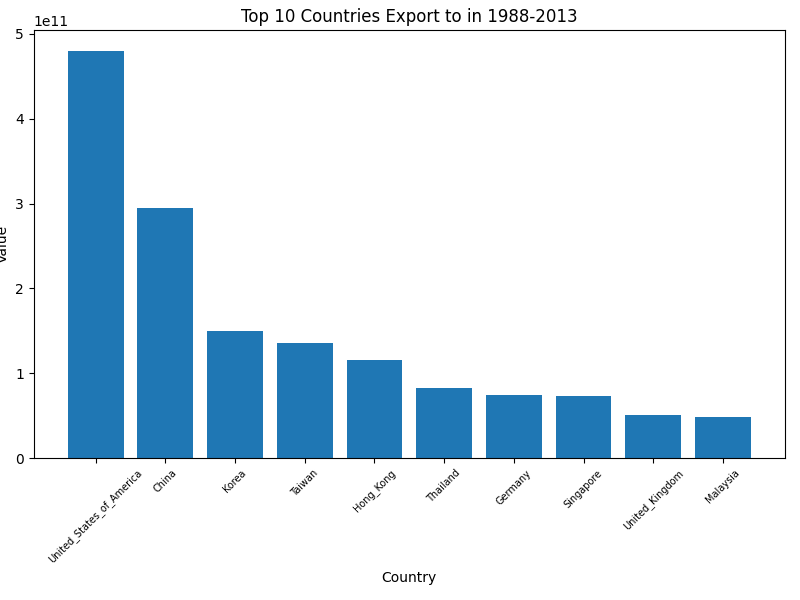

In [65]:
# Close previous plots; otherwise, will just overwrite and display again
plt.close()

plt.figure(figsize=(8,6))
plt.bar('Country_name2','sum(value)', data=by_ex_country)
plt.xlabel("Country")
plt.xticks(rotation=45, fontsize=7)
plt.tight_layout()
plt.ylabel("Value")
plt.title("Top 10 Countries Export to in 1988-2013")
%matplot plt

In [85]:
by_im_country = (data2.select("export_import", "country", "value")
                      .filter(data2.export_import == 2)
                      .groupby("country")
                      .sum("value")
                      .sort("sum(value)", ascending=False)
                      .limit(10)
                      .toPandas()
                )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [100]:
by_im_country = by_im_country.merge(country_codes_pd, left_on="country",right_on="Code", how="inner")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

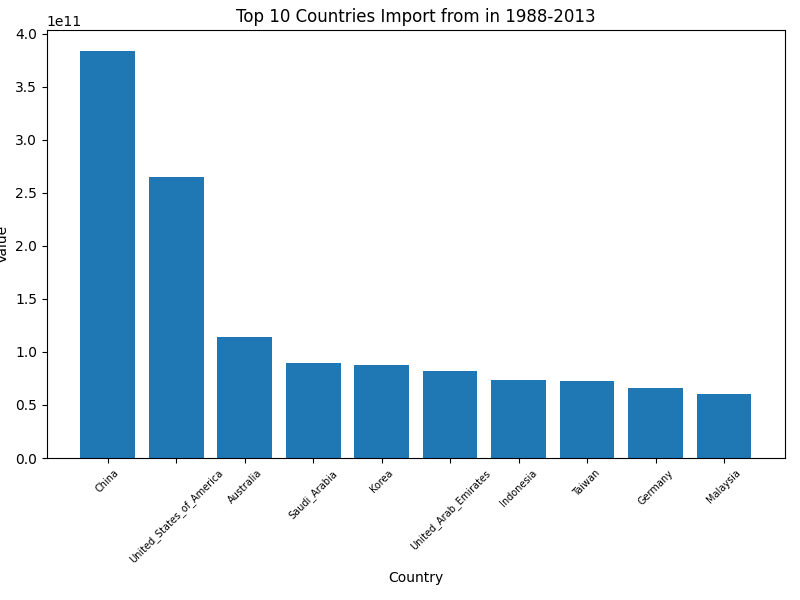

In [101]:
# Close previous plots; otherwise, will just overwrite and display again
plt.close()

plt.figure(figsize=(8,6))
plt.bar('Country_name2','sum(value)', data=by_im_country)
plt.xlabel("Country")
plt.xticks(rotation=45, fontsize=7)
plt.tight_layout()
plt.ylabel("Value")
plt.title("Top 10 Countries Import from in 1988-2013")
%matplot plt

### Plot time series of top10 trading partners (export)

In [167]:
ex_trend = (data2.filter(data2.country.isin(by_ex_country["Code"].values.tolist()))
                .filter(data2.export_import == 1)
                .select("year_month","country","value")
                .groupby("year_month","country")
                .sum("value")
                .toPandas()
           )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [168]:
ex_trend = ex_trend.merge(country_codes_pd, left_on="country",right_on="Code", how="inner")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [169]:
ex_trend["year_month"]=pd.to_datetime(ex_trend["year_month"],format="%Y%m")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

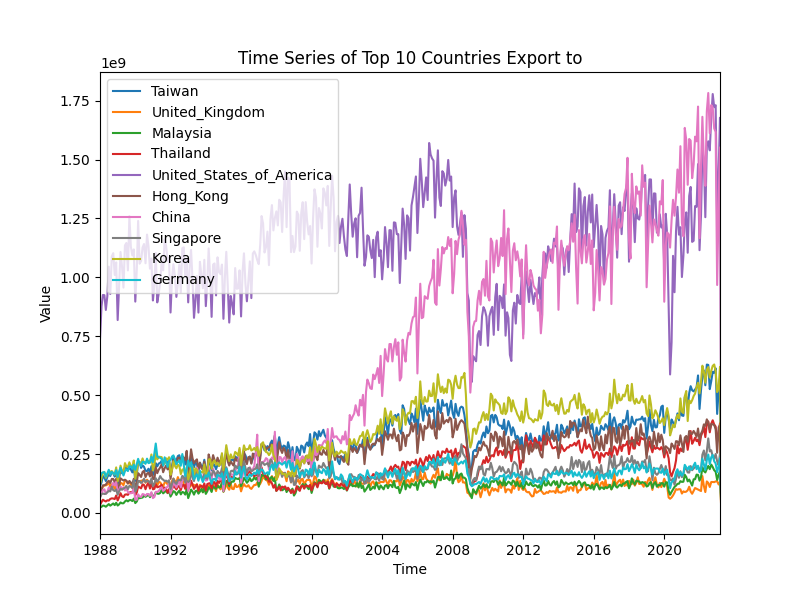

In [170]:
# Close previous plots; otherwise, will just overwrite and display again
import datetime
plt.close()

plt.figure(figsize=(8,6))

for c in ex_trend["Country_name2"].unique().tolist():
    temp = ex_trend[ex_trend["Country_name2"]==c].sort_values(by=['year_month'])
    x = temp["year_month"]
    y = temp["sum(value)"]  # Replace "your_y_column_name" with the actual column name from your DataFrame
    plt.plot(x, y, label=c)
plt.xlabel("Time")
plt.ylabel("Value")
plt.xlim([datetime.date(1988, 1, 1), datetime.date(2023, 3, 1)])
plt.legend()
plt.title("Time Series of Top 10 Countries Export to")
%matplot plt

In [171]:
im_trend = (data2.filter(data2.country.isin(by_im_country["Code"].values.tolist()))
                .filter(data2.export_import == 2)
                .select("year_month","country","value")
                .groupby("year_month","country")
                .sum("value")
                .toPandas()
           )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [172]:
im_trend = im_trend.merge(country_codes_pd, left_on="country",right_on="Code", how="inner")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [173]:
im_trend["year_month"]=pd.to_datetime(im_trend["year_month"],format="%Y%m")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

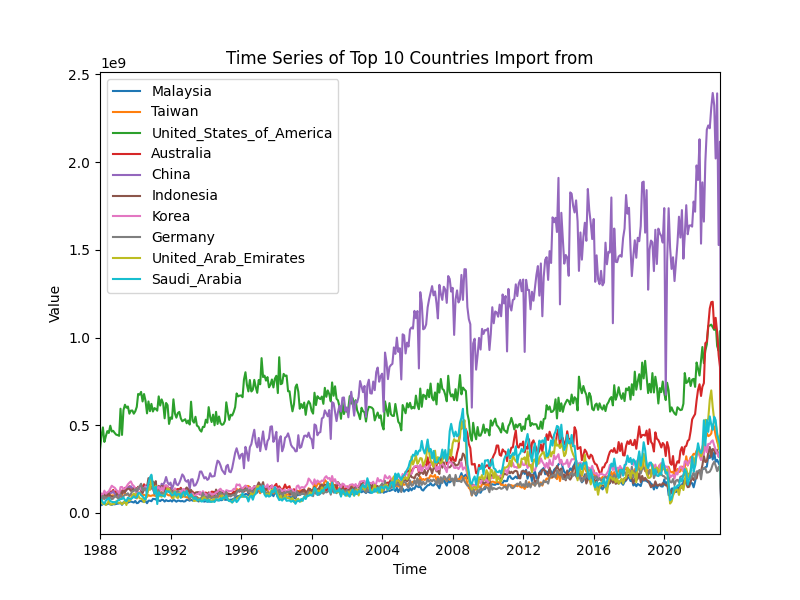

In [174]:
# Close previous plots; otherwise, will just overwrite and display again
plt.close()

plt.figure(figsize=(8,6))

for c in im_trend["Country_name2"].unique().tolist():
    temp = im_trend[im_trend["Country_name2"]==c].sort_values(by=['year_month'])
    x = temp["year_month"]
    y = temp["sum(value)"]  # Replace "your_y_column_name" with the actual column name from your DataFrame
    plt.plot(x, y, label=c)
plt.xlabel("Time")
plt.ylabel("Value")
plt.xlim([datetime.date(1988, 1, 1), datetime.date(2023, 3, 1)])
plt.legend()
plt.title("Time Series of Top 10 Countries Import from")
%matplot plt

### Top 10 HS9 codes export to

In [190]:
by_ex_hs9 = (data2.select("export_import", "hs9", "value")
                      .filter(data2.export_import == 1)
                      .groupby("hs9")
                      .sum("value")
                      .sort("sum(value)", ascending=False)
                      .limit(30)
                      .toPandas()
                )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [194]:
by_ex_hs9 = by_ex_hs9.merge(hs9_codes_pd, on="hs9", how="left")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [199]:
by_ex_hs9[["hs9","hs9_name","sum(value)"]][:10]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

         hs9                                           hs9_name   sum(value)
0        190                                   re_export_ohters  98573379742
1  870323929  Of_a_cylinder_capacity_exceeding_1_500_cc_but_...  52122216676
2  870324920          Of_a_cylinder_capacity_exceeding_3_000_cc  51618097691
3  870323919  Of_a_cylinder_capacity_exceeding_1_500_cc_but_...  42188425467
4  870840000                       Gear_boxes_and_parts_thereof  36477100570
5  890190100  Other_vessels_for_the_transport_of_goods_and_o...  27834937930
6  847330000  Parts_and_accessories_of_the_machines_of_headi...  26883636560
7  870323920                                                NaN  23956214083
8  847989900                                              Other  21268366650
9  870323910                                                NaN  20273093698

### Top 10 HS9 codes import from

In [196]:
by_im_hs9 = (data2.select("export_import", "hs9", "value")
                      .filter(data2.export_import == 2)
                      .groupby("hs9")
                      .sum("value")
                      .sort("sum(value)", ascending=False)
                      .limit(30)
                      .toPandas()
                )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [197]:
by_im_hs9 = by_im_hs9.merge(hs9_codes_pd, on="hs9", how="left")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [200]:
by_im_hs9[["hs9","hs9_name","sum(value)"]][:10]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

         hs9                                           hs9_name    sum(value)
0  270900900                                            -_Other  170374850243
1  271111000                                        Natural_gas  102826653017
2  270900090                                                NaN   42774855025
3  270900000  Petroleum_oils_and_oils_obtained_from_bitumino...   33835622683
4         99                                   re_import_ohters   29560517833
5  270112099                                           --_Other   27093481465
6  260111000                                   Non-agglomerated   25883165060
7  260300000                       Copper_ores_and_concentrates   23634200559
8  300490029                                           --_Other   19265548509
9  851712000  Telephones_for_cellular_networks_or_for_other_...   18829531062